In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
#from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct

def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [ ]:
original_samples = pd.read_csv('/gdrive/MyDrive/pr/unbalanced.csv')

In [ ]:
labeled_data_after_third_round = pd.read_csv('/gdrive/MyDrive/pr/labeled_data_after_thirdround.csv',sep='\t')
labeled_data_fourthround = pd.read_csv('/gdrive/MyDrive/pr/fourth_round_handlabeling.csv',sep='\t')

In [ ]:
labeled_data_fourthround

,Unnamed: 0,ID,Texts,labels
0,1048,1049,ঘাতক সেই বাস কোম্পানির মালিক নৌমন্ত্রীর শ্যালক...,non_depressive
1,1070,1071,"সিলেট , রাজশাহী , বরিশালের কবরস্থান গুলোতে আইন...",depressive
2,1148,1149,আজ আন্তর্জাতিক বাঘ দিবস । আপনি কি বাঘপ্রেমী ? ...,non_depressive
3,1179,1180,আগামীকাল সিলেটের নির্বাচনে যদি কোনো মৃত ব্যক্ত...,depressive
4,1193,1194,সম্যক পরিবার,non_depressive
...,...,...,...,...
74,3562,3563,কোন একদিন আমার বাসার লোকজন আমি পালিয়ে বিয়ে ক...,depressive
75,3567,3568,"মধ্য আয়ের দেশে উন্নীত হয়ে , বাংলাদেশ এখন ভাঙ...",depressive
76,3776,3777,এসো এই মুলুকে লতাপাতায় বেষ্টিত এইঘর খানায় । ...,non_depressive
77,3854,3855,মেয়েটা আমাকে খুব লাইক করে । মেয়েদের ধর্ম হইল...,non_depressive


In [ ]:
labeled_data_after_third_round.drop(labeled_data_after_third_round.columns[[0]], axis = 1, inplace = True)

In [ ]:
labeled_data_fourthround.drop(labeled_data_fourthround.columns[[0]], axis = 1, inplace = True)

In [ ]:
labeled_data_fourthround

,ID,Texts,labels
0,1049,ঘাতক সেই বাস কোম্পানির মালিক নৌমন্ত্রীর শ্যালক...,non_depressive
1,1071,"সিলেট , রাজশাহী , বরিশালের কবরস্থান গুলোতে আইন...",depressive
2,1149,আজ আন্তর্জাতিক বাঘ দিবস । আপনি কি বাঘপ্রেমী ? ...,non_depressive
3,1180,আগামীকাল সিলেটের নির্বাচনে যদি কোনো মৃত ব্যক্ত...,depressive
4,1194,সম্যক পরিবার,non_depressive
...,...,...,...
74,3563,কোন একদিন আমার বাসার লোকজন আমি পালিয়ে বিয়ে ক...,depressive
75,3568,"মধ্য আয়ের দেশে উন্নীত হয়ে , বাংলাদেশ এখন ভাঙ...",depressive
76,3777,এসো এই মুলুকে লতাপাতায় বেষ্টিত এইঘর খানায় । ...,non_depressive
77,3855,মেয়েটা আমাকে খুব লাইক করে । মেয়েদের ধর্ম হইল...,non_depressive


In [ ]:
labeled_data_after_third_round

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
1476,3898,আসল অপরাধী ঐ শাজাহান সহ কর্তাব্যক্তিদের । আদতে...,depressive
1477,3899,সুষ্ঠ এবং নির্ভেজাল নির্বাচন দেখতে চান তাইলে ব...,depressive
1478,3900,"ঘণ্টাখানেক সঙ্গে সুমন , সন্ধে ৭ । বিষয় রাতারা...",depressive
1479,3902,"১৫ কেন্দ্রে জাল ভোট , বিএনপির দাবি ৪১ :",non_depressive


In [ ]:
all_labeled = pd.DataFrame()

In [ ]:
all_labeled = pd.concat([labeled_data_after_third_round, labeled_data_fourthround])

In [ ]:
all_labeled

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
74,3563,কোন একদিন আমার বাসার লোকজন আমি পালিয়ে বিয়ে ক...,depressive
75,3568,"মধ্য আয়ের দেশে উন্নীত হয়ে , বাংলাদেশ এখন ভাঙ...",depressive
76,3777,এসো এই মুলুকে লতাপাতায় বেষ্টিত এইঘর খানায় । ...,non_depressive
77,3855,মেয়েটা আমাকে খুব লাইক করে । মেয়েদের ধর্ম হইল...,non_depressive


In [ ]:
unlabeled_remained = original_samples.loc[~original_samples['ID'].isin(all_labeled['ID'])]

In [ ]:
unlabeled_remained

,ID,Texts,labels
1000,1001,কখনো আয়নার সামনে দাঁড়িয়ে নিজের প্রেমে পড়েছ...,depressive
1001,1002,মনের বিরুদ্ধে গিয়ে কোন কাজ করলে সফল হওয়ার চা...,non_depressive
1002,1003,"সব ভালোবাসা প্রেম নয় , কিছু ভালোবাসা বন্ধুত্ব...",non_depressive
1003,1004,"অন্যায় যখন সীমা ছাড়ায় , প্রতিবাদ তখন করতেই ...",non_depressive
1004,1005,কিসের যেন একটা অভাব দেহের ভিতর বসবাস করছে । মা...,depressive
...,...,...,...
3908,3909,দুনিয়ায় যত অনুপ্রবেশকারী তড়িপার দেশদ্রোহী আ...,non_depressive
3909,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,non_depressive
3911,3912,ছবিটাতে অনেক কিছু বুঝিয়ে দিলো । পশু হলেও তার ...,non_depressive
3912,3913,পৃথিবীতে নিজেকে নিয়ে গর্ব করার কিছু নেই সব গর...,non_depressive


In [ ]:
all_labeled.reset_index(drop=True)

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
1555,3563,কোন একদিন আমার বাসার লোকজন আমি পালিয়ে বিয়ে ক...,depressive
1556,3568,"মধ্য আয়ের দেশে উন্নীত হয়ে , বাংলাদেশ এখন ভাঙ...",depressive
1557,3777,এসো এই মুলুকে লতাপাতায় বেষ্টিত এইঘর খানায় । ...,non_depressive
1558,3855,মেয়েটা আমাকে খুব লাইক করে । মেয়েদের ধর্ম হইল...,non_depressive


In [ ]:
unlabeled_remained.reset_index(drop=True)

,ID,Texts,labels
0,1001,কখনো আয়নার সামনে দাঁড়িয়ে নিজের প্রেমে পড়েছ...,depressive
1,1002,মনের বিরুদ্ধে গিয়ে কোন কাজ করলে সফল হওয়ার চা...,non_depressive
2,1003,"সব ভালোবাসা প্রেম নয় , কিছু ভালোবাসা বন্ধুত্ব...",non_depressive
3,1004,"অন্যায় যখন সীমা ছাড়ায় , প্রতিবাদ তখন করতেই ...",non_depressive
4,1005,কিসের যেন একটা অভাব দেহের ভিতর বসবাস করছে । মা...,depressive
...,...,...,...
2349,3909,দুনিয়ায় যত অনুপ্রবেশকারী তড়িপার দেশদ্রোহী আ...,non_depressive
2350,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,non_depressive
2351,3912,ছবিটাতে অনেক কিছু বুঝিয়ে দিলো । পশু হলেও তার ...,non_depressive
2352,3913,পৃথিবীতে নিজেকে নিয়ে গর্ব করার কিছু নেই সব গর...,non_depressive


In [ ]:
all_labeled['Texts']
all_labeled['labels']

0     non_depressive
1     non_depressive
2     non_depressive
3     non_depressive
4     non_depressive
           ...      
74        depressive
75        depressive
76    non_depressive
77    non_depressive
78    non_depressive
Name: labels, Length: 1560, dtype: object

In [ ]:
for i in range(len(all_labeled)):
  if all_labeled['labels'].values[i] =="non_depressive":
    all_labeled['labels'].values[i]=1
  elif all_labeled['labels'].values[i] =="depressive":
    all_labeled['labels'].values[i]=0

In [ ]:
all_labeled

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,1
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,1
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,1
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,1
...,...,...,...
74,3563,কোন একদিন আমার বাসার লোকজন আমি পালিয়ে বিয়ে ক...,0
75,3568,"মধ্য আয়ের দেশে উন্নীত হয়ে , বাংলাদেশ এখন ভাঙ...",0
76,3777,এসো এই মুলুকে লতাপাতায় বেষ্টিত এইঘর খানায় । ...,1
77,3855,মেয়েটা আমাকে খুব লাইক করে । মেয়েদের ধর্ম হইল...,1


In [ ]:
all_labeled['Texts'] = all_labeled.Texts.apply(lambda x: preprocessing(str(x)))
all_labeled.head()

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,1
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,1
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,1
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,1


In [ ]:
data1 =pd.read_excel('/gdrive/MyDrive/pr/stopwords_bangla.xlsx')
stop = data1['words'].tolist()

In [ ]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

In [ ]:
all_labeled['Texts'] = all_labeled.Texts.apply(lambda x: stopwordRemoval(str(x)))
all_labeled.head(15)

,ID,Texts,labels
0,1,জনগণের ভোট চুরি ক্ষমতায় নিয়ত আওয়ামী লীগ নেত...,1
1,2,সবথেকে যুদ্ধ মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে পড়বে যখনিই জ্যোস্না হাসে তোমাকে পড়বে ...,1
3,4,রোজ আকাশে একটা জলমল করতো মেঘলা ঘন বর্ষাতেও খুঁ...,1
4,5,আল্লাহ মহাপরাক্রমশালী ওপর পরিপূর্ণরূপে বিজয়ী ...,1
5,6,নিষিদ্ধ পল্লীতে নিষিদ্ধ মানুষের বসবাস থাকলেও স...,1
6,7,কেমন আছেন আশা ভালো আছেন,1
7,8,ধৈর্য্য সফলতা সমস্যা ধৈয্যধারন ক্ষমতা তুলো গোছের,1
8,9,গতকাল হুগলী জেলার রিষড়ার হেস্টিংস জুট মিলের শ...,1
9,10,অভিনন্দন,1


In [ ]:
X = all_labeled["Texts"].values
y = all_labeled["labels"].values
print(y)

[1 1 1 ... 1 1 1]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

In [ ]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1404
156
1404
156


In [ ]:
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add, Flatten
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn import svm
from keras.utils.vis_utils import plot_model

In [ ]:
test_ck = pd.DataFrame(X_train)
test_ck.columns = ["Response"]

length_of_the_messages = test_ck["Response"].str.split("\\s+")


print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.str.len().idxmax())

Max number of words =  42
Index =  158


In [ ]:
num_words = 20000 #Max. words to use per comment
max_features = 60000 #Max. number of unique words in embeddinbg vector
max_len = 64 #Max. number of words per toxic comment to be use
embedding_dims = 64 #embedding vector output dimension 
num_epochs = 100 # (before 5)number of epochs (number of times that the model is exposed to the training dataset)
val_split = 0.05
batch_size2 = 24

In [ ]:
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(X_train)

#Convert tokenized commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
# padding the sequences
X_train = pad_sequences(X_train, max_len, padding='post')
X_test  = pad_sequences(X_test,  max_len, padding='post')

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (1404, 64)
X_test shape:  (156, 64)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size =0.95, random_state=233)

In [ ]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=8)

In [ ]:
#GLoVE Loading
glove_file = open('/gdrive/MyDrive/pr/bn_glove.39M.300d.txt', encoding="utf8")
embeddings_index = dict()
for line in glove_file:
    val = line.split(' ')
    word = val[0]
    coefs = np.asarray(val[1:], dtype='float32')
    embeddings_index[word] = coefs
glove_file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 178153 word vectors.


In [ ]:
print(len(tokenizer.word_index)+1)

6436


In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape[0]

6436

In [ ]:
LSTM_model = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False),
    #So, using this feature will enable the model to look at the context on both the left and the right.
    LSTM(64, return_sequences=True),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    GlobalMaxPool1D(),
    Dense(32, activation = 'relu'),
    Dropout(0.1),
    Dense(16, activation = 'relu'),
    Dropout(0.1),
    Dense(2, activation = 'sigmoid')
])

LSTM_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [ ]:
LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 64, 300)           1930800   
                                                                 
 lstm_2 (LSTM)               (None, 64, 64)            93440     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                      

In [ ]:
LSTM_model_fit = LSTM_model.fit(X_train, y_train, batch_size=16, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/100
84/84 [==============================] - 1s 7ms/step - loss: 0.1180 - accuracy: 0.9205 - val_loss: 1.1320 - val_accuracy: 0.8169
Epoch 2/100
84/84 [==============================] - 1s 7ms/step - loss: 0.1113 - accuracy: 0.9272 - val_loss: 1.0917 - val_accuracy: 0.8169
Epoch 3/100
84/84 [==============================] - 1s 7ms/step - loss: 0.1041 - accuracy: 0.9310 - val_loss: 1.3546 - val_accuracy: 0.8169
Epoch 4/100
84/84 [==============================] - 1s 6ms/step - loss: 0.1054 - accuracy: 0.9235 - val_loss: 1.1748 - val_accuracy: 0.8310
Epoch 5/100
84/84 [==============================] - 1s 6ms/step - loss: 0.1032 - accuracy: 0.9280 - val_loss: 1.2646 - val_accuracy: 0.8310
Epoch 6/100
84/84 [==============================] - 1s 7ms/step - loss: 0.1120 - accuracy: 0.9302 - val_loss: 1.0683 - val_accuracy: 0.7887
Epoch 7/100
84/84 [==============================] - 1s 7ms/step - loss: 0.1363 - accuracy: 0.9250 - val_loss: 0.7678 - val_accuracy: 0.8169
Epoch 8/100
8

In [ ]:
pred_lstm = LSTM_model.predict(X_test)

5/5 [==============================] - 0s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score
pred_round = np.round(pred_lstm)  
score = accuracy_score(y_test,pred_round)
score

0.7564102564102564

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Normal', 'Depression-Indicative']
print(classification_report(y_test, pred_round, target_names=target_names))

                       precision    recall  f1-score   support

               Normal       0.59      0.71      0.64        48
Depression-Indicative       0.86      0.78      0.82       108

            micro avg       0.76      0.76      0.76       156
            macro avg       0.72      0.74      0.73       156
         weighted avg       0.77      0.76      0.76       156
          samples avg       0.76      0.76      0.76       156



In [ ]:
print(np.around(pred_lstm,3))

[[0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [1.    0.   ]
 [0.51  0.489]
 [0.997 0.003]
 [0.    1.   ]
 [0.    1.   ]
 [0.316 0.684]
 [0.    1.   ]
 [0.    1.   ]
 [0.472 0.529]
 [0.    1.   ]
 [1.    0.   ]
 [0.51  0.489]
 [0.    1.   ]
 [0.007 0.993]
 [1.    0.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.    1.   ]
 [1.    0.   ]
 [0.002 0.998]
 [1.    0.   ]
 [1.    0.   ]
 [0.51  0.489]
 [0.51  0.489]
 [1.    0.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.51  0.489]
 [0.51  0.489]
 [0.    1.   ]
 [0.    1.   ]
 [0.51  0.489]
 [0.51  0.489]
 [0.51  0.489]
 [0.    1.   ]
 [0.023 0.977]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.51  0.489]
 [1.    0.   ]
 [0.    1.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.51  0.489]
 [0.    1.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.997 0.003]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.937 0.063]
 [0.51  0.489]
 [0.    1.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [1.    0.

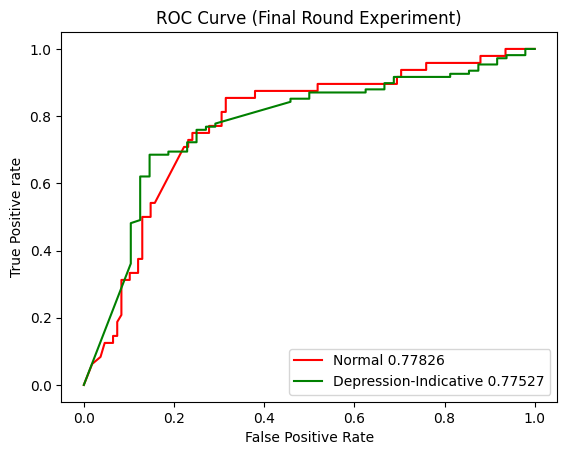

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc = {}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test.argmax(axis=1), pred_lstm[:,i], pos_label=i)
    roc[i]   = roc_auc_score(y_test[:,i], pred_lstm[:,i], multi_class='ovo')

    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='solid',color='Red', label= 'Normal '+ str(round(roc[0],6)))
plt.plot(fpr[1], tpr[1], linestyle='solid',color='green', label= 'Depression-Indicative '+ str(round(roc[1],6)))



plt.title('ROC Curve (Final Round Experiment)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

plt.savefig('ROC Curve (4th Round Experiment)',dpi=300);

In [ ]:
unlabeled_texts = unlabeled_remained["Texts"].values
#Convert tokenized commnent to sequnces
unlabeled_texts = tokenizer.texts_to_sequences(unlabeled_texts)

 # padding the sequences
unlabeled_texts = pad_sequences(unlabeled_texts, max_len, padding='post')

In [ ]:
pred_unlabeled = LSTM_model.predict(unlabeled_texts)

74/74 [==============================] - 0s 3ms/step


In [ ]:
print(np.around(pred_unlabeled,3))
print(pred_unlabeled.shape)

[[0.    1.   ]
 [0.    1.   ]
 [0.412 0.588]
 ...
 [1.    0.   ]
 [0.    1.   ]
 [1.    0.   ]]
(2354, 2)


In [ ]:
need_handlabeling = pd.DataFrame(columns=['ID','Texts', 'labels'])

In [ ]:
def least_confi(arr):
      
    # get number of rows and columns
    no_of_rows = arr.shape[0]
    no_of_column = arr.shape[1]
    num_labels = 2 
    cnt = 0;
   
    nh_index = 0
    for i in range(no_of_rows):
          
        # Initialize max1 to 0 at beginning
        # of finding max element of each row
        most_conf = 0
        for j in range(no_of_column):
            if arr[i][j] > most_conf :
                most_conf = arr[i][j]
                numerator = (num_labels * (1 - most_conf))
                denominator = (num_labels - 1)
                least_conf = numerator / denominator

                
                  
        # print maximum element of each row
        print(cnt,".",least_conf)
        
        if(least_conf>0.7): #if the confidence score is greater than 0.6, sample requires handlabeling 
          need_handlabeling.loc[nh_index] = unlabeled_remained.iloc[cnt]
          print("Done")
          nh_index = nh_index + 1
        cnt = cnt+1

In [ ]:
least_confi(pred_unlabeled)

0 . 0.0
1 . 1.1920928955078125e-06
2 . 0.823161244392395
Done
3 . 0.0
4 . 0.0007357597351074219
5 . 0.0
6 . 0.0
7 . 9.5367431640625e-06
8 . 0.0
9 . 0.0
10 . 0.0
11 . 0.00037920475006103516
12 . 2.384185791015625e-07
13 . 0.0
14 . 0.0
15 . 4.00543212890625e-05
16 . 4.5299530029296875e-06
17 . 6.031990051269531e-05
18 . 0.0
19 . 0.0
20 . 0.0
21 . 0.0
22 . 0.0
23 . 0.0
24 . 0.0
25 . 0.0
26 . 0.0
27 . 0.0
28 . 0.0
29 . 0.00018286705017089844
30 . 0.0
31 . 0.0
32 . 1.6450881958007812e-05
33 . 0.0
34 . 0.00010418891906738281
35 . 0.0
36 . 8.106231689453125e-05
37 . 0.0
38 . 0.0
39 . 7.796287536621094e-05
40 . 2.86102294921875e-06
41 . 4.76837158203125e-07
42 . 0.0
43 . 4.76837158203125e-07
44 . 2.384185791015625e-07
45 . 3.9577484130859375e-05
46 . 0.0
47 . 0.0
48 . 0.0
49 . 0.00036394596099853516
50 . 2.5510787963867188e-05
51 . 0.0
52 . 2.384185791015625e-07
53 . 0.02629375457763672
54 . 0.0
55 . 9.870529174804688e-05
56 . 0.0
57 . 0.0
58 . 1.1920928955078125e-06
59 . 0.0
60 . 2.0503997802

In [176]:
final_round_handlabeling = pd.DataFrame()

In [177]:
final_round_handlabeling = original_samples.loc[original_samples['ID'].isin(need_handlabeling['ID'])]

In [179]:
print(final_round_handlabeling.shape)

(45, 3)


In [180]:
final_round_handlabeling.to_csv('final_round_handlabeling.csv',sep='\t')

In [181]:
labeled_data_after_fourth_round = pd.DataFrame()

In [182]:
labeled_data_after_fourth_round = original_samples.loc[original_samples['ID'].isin(all_labeled['ID'])]

In [183]:
labeled_data_after_fourth_round 

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
3897,3898,আসল অপরাধী ঐ শাজাহান সহ কর্তাব্যক্তিদের । আদতে...,depressive
3898,3899,সুষ্ঠ এবং নির্ভেজাল নির্বাচন দেখতে চান তাইলে ব...,depressive
3899,3900,"ঘণ্টাখানেক সঙ্গে সুমন , সন্ধে ৭ । বিষয় রাতারা...",depressive
3901,3902,"১৫ কেন্দ্রে জাল ভোট , বিএনপির দাবি ৪১ :",non_depressive


In [184]:
total_labeled = pd.concat([labeled_data_after_fourth_round, final_round_handlabeling])

In [185]:
total_labeled

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
3678,3679,"আমি মাপতে যাইনা হিমালয়ের উচ্চতা , আমি মাপতে য...",non_depressive
3830,3831,ছাএদল ও একটা সংগঠন ! তেইল্লাচুরা ও একটা পাখি ;...,depressive
3839,3840,ফিমেইল গুলা থেকে যখন কোনো ক্যাপশন ছাড়াই তাদের...,depressive
3849,3850,অসমৰ আভ্যন্তৰীণ বিষয়ত কিয় হস্তক্ষেপ বংগৰ মুখ...,non_depressive


In [256]:
total_labeled.to_csv('total_hand_labeled.csv',sep='\t')

In [231]:
unlabeled_remained = original_samples.loc[~original_samples['ID'].isin(total_labeled['ID'])]

In [232]:
unlabeled_remained

,ID,Texts,labels
1000,1001,কখনো আয়নার সামনে দাঁড়িয়ে নিজের প্রেমে পড়েছ...,depressive
1001,1002,মনের বিরুদ্ধে গিয়ে কোন কাজ করলে সফল হওয়ার চা...,non_depressive
1003,1004,"অন্যায় যখন সীমা ছাড়ায় , প্রতিবাদ তখন করতেই ...",non_depressive
1004,1005,কিসের যেন একটা অভাব দেহের ভিতর বসবাস করছে । মা...,depressive
1005,1006,আপনার কাছে কোন জেলার ভাষা বেশি কঠিন মনে হয় এব...,non_depressive
...,...,...,...
3908,3909,দুনিয়ায় যত অনুপ্রবেশকারী তড়িপার দেশদ্রোহী আ...,non_depressive
3909,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,non_depressive
3911,3912,ছবিটাতে অনেক কিছু বুঝিয়ে দিলো । পশু হলেও তার ...,non_depressive
3912,3913,পৃথিবীতে নিজেকে নিয়ে গর্ব করার কিছু নেই সব গর...,non_depressive


In [233]:
true_unlabeled = unlabeled_remained

In [234]:
final = unlabeled_remained["Texts"].values

In [235]:
final = tokenizer.texts_to_sequences(final)

 # padding the sequences
final = pad_sequences(final, max_len, padding='post')

In [236]:
pred_final = LSTM_model.predict(final)

73/73 [==============================] - 0s 3ms/step


In [237]:
print(np.around(pred_final,3))
print(pred_final.shape)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
(2309, 2)


In [238]:
print(np.around(pred_final))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [239]:
final_y = unlabeled_remained['labels'].values

In [240]:
for i in range(len(unlabeled_remained)):
  if unlabeled_remained['labels'].values[i] =="non_depressive":
    unlabeled_remained['labels'].values[i]=1
  elif unlabeled_remained['labels'].values[i] =="depressive":
    unlabeled_remained['labels'].values[i]=0

In [241]:
final_y = to_categorical(final_y, num_classes=2)

In [242]:
score = accuracy_score(final_y,np.around(pred_final))
score

0.8362927674317887

In [253]:
print(unlabeled_remained["Texts"].values[10],unlabeled_remained['labels'].values[10], final_y[10].argmax(), np.around(pred_final[10]).argmax())
print(unlabeled_remained["Texts"].values[1],unlabeled_remained['labels'].values[1], final_y[1].argmax(), np.around(pred_final[1]).argmax())

কে ভেবেছিল প্রাণগুলো এভাবে ঝড়ে যাবে রাস্তায় ? ধিক্কার ওসব বাস ড্রাইবারদের । ওদের ছেলেমেয়েগুলো এভাবে মারা গেলে বুঝবে , এ ঝড়ে যাওয়া কত টা কষ্টের 0 0 0
মনের বিরুদ্ধে গিয়ে কোন কাজ করলে সফল হওয়ার চান্স খুব কম ! কারন মন আর শরীর দুটোর সম্মিলিত প্রচেষ্টার মাধ্যমেই যে কোন কাজে সফলতা আসে ! 1 1 1


In [250]:
np.around(pred_final[1]) == [[1][0]]

array([False,  True])

In [254]:
for i in range(len(unlabeled_remained)):
  if np.around(pred_final[i]).argmax() == 0:
    unlabeled_remained['labels'].values[i]="depressive"
  elif np.around(pred_final[i]).argmax() == 1:
    unlabeled_remained['labels'].values[i]="non_depressive"

In [255]:
unlabeled_remained.to_csv('final_data_hand_labeling.csv',sep='\t')